## Libraries

In [45]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import utils
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import urllib.request as request
from matplotlib import pyplot as plt

from tqdm import tqdm, trange

from collections import Counter

## Data

In [57]:
data_path = 'CIFAR1/data'
train = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.Compose([
                            transforms.Grayscale(num_output_channels=1), 
                            transforms.ToTensor()]))

test = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms.Compose([
                            transforms.Grayscale(num_output_channels=1), 
                            transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [58]:
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
print(f'Original labels: {classes}\n')
print(f'Trainset:\t[{len(train)}, {len(train[0])}, {len(train[0][0])}, {len(train[0][0][0])}, {len(train[0][0][0][0])}]')
print(f'Testset:\t[{len(test)}, {len(test[0])}, {len(test[0][0])}, {len(test[0][0][0])}, {len(test[0][0][0][0])}]')

Original labels: ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Trainset:	[50000, 2, 1, 32, 32]
Testset:	[10000, 2, 1, 32, 32]


In [59]:
dc = [3,4,5,6,9]

t_label=[]
t_img=[]

for img, label in train:
    if label != dc[0] and label != dc[1] and label != dc[2] and label != dc[3] and label != dc[4]:
        t_img.append(img)
        t_label.append(label)
    

v_label=[]
v_img=[]

for img, label in test:
    if label != dc[0] and label != dc[1] and label != dc[2] and label != dc[3] and label != dc[4]:
        v_img.append(img)
        v_label.append(label)

        
erased=[]
for i in range(len(dc)):
    erased.append(classes.pop(dc[i]-i))
    
print(f'Erased labels: {erased}')

t_label = [3 if x == 8 else x for x in t_label]
t_label = [4 if x == 7 else x for x in t_label]

v_label = [3 if x == 8 else x for x in v_label]
v_label = [4 if x == 7 else x for x in v_label]

Erased labels: ['cat', 'deer', 'dog', 'frog', 'truck']


In [62]:
print(f'Number of labels: {len(classes)}')
print(f'Final labels: {classes}')

f_index=list(Counter(t_label).keys())
f_index.sort()

print(f'Final index: {f_index}\n')


X_s = torch.Tensor(len(t_img), len(t_img[0]), len(t_img[0][0]), len(t_img[0][0][0]))
X_a_s = torch.Tensor(len(v_img), len(v_img[0]), len(v_img[0][0]), len(v_img[0][0][0]))

print(f'Trainset:\t{X_s.shape}\tLabels:\t{len(t_label)}')
print(f'Testset:\t{X_a_s.shape}\tLabels:\t{len(v_label)}\n\n')

X = torch.cat(t_img, dim=0, out=X_s)
Y = torch.tensor(t_label)

X_a = torch.cat(v_img, dim=0, out=X_a_s)
Y_a = torch.tensor(v_label)

print(f'Trainset:\t{X.shape}')
print(f'Testset:\t{X_a.shape}')

Number of labels: 5
Final labels: ['plane', 'car', 'bird', 'horse', 'ship']
Final index: [0, 1, 2, 3, 4]

Trainset:	torch.Size([25000, 1, 32, 32])	Labels:	25000
Testset:	torch.Size([5000, 1, 32, 32])	Labels:	5000


Trainset:	torch.Size([25000, 32, 32])
Testset:	torch.Size([5000, 32, 32])


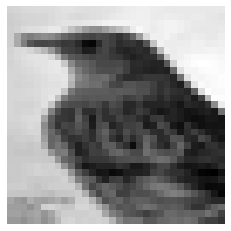

In [108]:
plt.imshow(X[8],cmap='gray')
plt.axis('off')
plt.show()

## Network

In [50]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        
        self.fc1=nn.Linear(32*5*5, 170, bias=True)
        self.fc2=nn.Linear(170, 56, bias=True)
        self.fc3=nn.Linear(56, 5, bias=True)
    
    def forward(self,x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        x = torch.flatten(x, start_dim=1)
        
        x= F.relu(self.fc1(x)) 
        x= F.relu(self.fc2(x))
        x= self.fc3(x)
        
        return F.softmax(x, dim=1)

## CUDA

In [51]:
torch.cuda.empty_cache()
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    net_class = Net().to(device)
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    net_class = Net()
    print("Running on the CPU")

Running on the GPU


## Training loop

In [53]:
batch_size = 10
epochs = 35

optimizer = optim.Adam(net_class.parameters(),lr= 0.0008)
loss_function = nn.CrossEntropyLoss()

loss_grap=[]
mean_grap=[]
prin = True

for epoch in range(epochs):
    loss_mean=0
    for i in trange(0, len(X), batch_size,  desc='Loss calculation'):
        
        batch_X=X[i:i+batch_size].view(-1,1,32,32)
        batch_y=Y[i:i+batch_size]
        
        x,y = batch_X.to(device), batch_y.to(device)
        
        net_class.zero_grad()
        
        output=net_class(x.view(-1,1,32,32))
        
        if prin:
            print(f'Output shape: {output.shape}\t Y shape: {y.shape}')
            prin = False
        
        loss = loss_function(output, y)
        
        loss.backward()
        
        optimizer.step()
        
        loss_grap.append(loss)
    
        loss_mean+=loss
        
    print(f'Epoch {epoch+1} error mean {((loss_mean/i).item()):.5f}')
    mean_grap.append((loss_mean/i).item())

Loss calculation:   0%|          | 6/2500 [00:00<00:41, 59.57it/s]

Output shape: torch.Size([10, 5])	 Y shape: torch.Size([10])


Loss calculation:   0%|          | 8/2500 [00:00<00:34, 72.64it/s]

Epoch 1 error mean 0.13939


Loss calculation:   0%|          | 7/2500 [00:00<00:36, 68.54it/s]

Epoch 2 error mean 0.12834


Loss calculation:   0%|          | 7/2500 [00:00<00:37, 67.19it/s]

Epoch 3 error mean 0.12273


Loss calculation:   0%|          | 6/2500 [00:00<00:43, 57.19it/s]

Epoch 4 error mean 0.11899


Loss calculation:   0%|          | 7/2500 [00:00<00:36, 68.69it/s]

Epoch 5 error mean 0.11691


Loss calculation:   0%|          | 7/2500 [00:00<00:36, 68.81it/s]

Epoch 6 error mean 0.11540


Loss calculation:   0%|          | 7/2500 [00:00<00:36, 67.59it/s]

Epoch 7 error mean 0.11390


Loss calculation:   0%|          | 7/2500 [00:00<00:36, 68.94it/s]

Epoch 8 error mean 0.11291


Loss calculation:   0%|          | 8/2500 [00:00<00:33, 73.91it/s]

Epoch 9 error mean 0.11201


Loss calculation:   0%|          | 6/2500 [00:00<00:44, 56.20it/s]

Epoch 10 error mean 0.11152


Loss calculation:   0%|          | 8/2500 [00:00<00:34, 71.37it/s]

Epoch 11 error mean 0.11034


Loss calculation:   0%|          | 8/2500 [00:00<00:33, 73.54it/s]

Epoch 12 error mean 0.10989


Loss calculation:   0%|          | 7/2500 [00:00<00:37, 65.65it/s]

Epoch 13 error mean 0.10859


Loss calculation:   0%|          | 8/2500 [00:00<00:33, 74.80it/s]

Epoch 14 error mean 0.10855


Loss calculation:   0%|          | 7/2500 [00:00<00:35, 69.54it/s]

Epoch 15 error mean 0.10806


Loss calculation:   0%|          | 6/2500 [00:00<00:42, 58.37it/s]

Epoch 16 error mean 0.10730


Loss calculation:   0%|          | 8/2500 [00:00<00:34, 73.06it/s]

Epoch 17 error mean 0.10662


Loss calculation:   0%|          | 7/2500 [00:00<00:37, 67.34it/s]

Epoch 18 error mean 0.10622


Loss calculation:   0%|          | 8/2500 [00:00<00:32, 75.68it/s]

Epoch 19 error mean 0.10568


Loss calculation:   0%|          | 8/2500 [00:00<00:34, 72.51it/s]

Epoch 20 error mean 0.10567


Loss calculation:   0%|          | 7/2500 [00:00<00:36, 68.52it/s]

Epoch 21 error mean 0.10560


Loss calculation:   0%|          | 6/2500 [00:00<00:43, 57.97it/s]

Epoch 22 error mean 0.10526


Loss calculation:   0%|          | 8/2500 [00:00<00:34, 73.29it/s]

Epoch 23 error mean 0.10510


Loss calculation:   0%|          | 7/2500 [00:00<00:37, 65.94it/s]

Epoch 24 error mean 0.10495


Loss calculation:   0%|          | 7/2500 [00:00<00:40, 62.02it/s]

Epoch 25 error mean 0.10483


Loss calculation:   0%|          | 8/2500 [00:00<00:34, 71.95it/s]

Epoch 26 error mean 0.10461


Loss calculation:   0%|          | 7/2500 [00:00<00:36, 69.03it/s]

Epoch 27 error mean 0.10467


Loss calculation:   0%|          | 8/2500 [00:00<00:33, 74.68it/s]

Epoch 28 error mean 0.10400


Loss calculation:   0%|          | 8/2500 [00:00<00:35, 70.27it/s]

Epoch 29 error mean 0.10403


Loss calculation:   0%|          | 7/2500 [00:00<00:37, 67.19it/s]

Epoch 30 error mean 0.10418


Loss calculation:   0%|          | 8/2500 [00:00<00:34, 72.21it/s]

Epoch 31 error mean 0.10420


Loss calculation:   0%|          | 7/2500 [00:00<00:35, 69.96it/s]

Epoch 32 error mean 0.10421


Loss calculation:   0%|          | 7/2500 [00:00<00:40, 61.68it/s]

Epoch 33 error mean 0.10395


Loss calculation:   0%|          | 7/2500 [00:00<00:36, 67.87it/s]

Epoch 34 error mean 0.10340


Loss calculation: 100%|██████████| 2500/2500 [00:34<00:00, 72.00it/s]

Epoch 35 error mean 0.10334


## Error

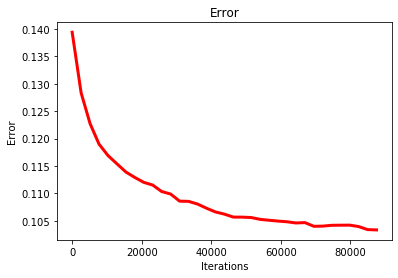

In [54]:
xpt=np.linspace(0,len(loss_grap),len(mean_grap))
xpt=[int(i) for i in xpt]

plt.plot(xpt,mean_grap,c='red',lw=3)

plt.title('Error')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()

## Accuracy

In [64]:
correct = 0
total = 0
with torch.no_grad():
    
    for i in trange(len(X_a), desc='Accuracy calculation'):
        
        X_a,Y_a = X_a.to(device), Y_a.to(device)
        
        net_out = net_class(X_a[i].view(-1,1,32,32))[0]
        
        predicted_class = torch.argmax(net_out)
        
        if predicted_class == Y_a[i]:
            correct += 1
        total += 1

print("Accuracy: ",round(correct/total,3))

Accuracy calculation: 100%|██████████| 5000/5000 [00:12<00:00, 395.26it/s]

Accuracy:  0.772


## New data

In [127]:
f_class=['Plane', 'Car', 'Bird','Ship', 'Horse']

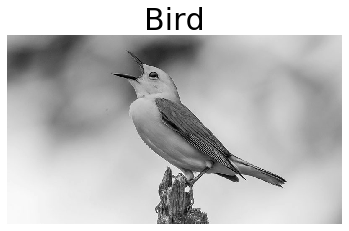

In [134]:
import cv2 

#Path
path1 = r'CIFAR1\imgs\der.jpg'
path2 = r'CIFAR1\imgs\carr.jpg'
path3 = r'CIFAR1\imgs\shi.png'
path4 = r'CIFAR1\imgs\pig.jpg'
path5 = r'CIFAR1\imgs\plan.jpg'
path6 = r'CIFAR1\imgs\pgu.jpg'

#Image transformation
img1 = cv2.imread(path6, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img1, (32, 32))
innn = torch.Tensor([i for i in img])
innn = innn.to(device)

net_res = net_class(innn.view(-1,1,32,32))
p_class = torch.argmax(net_res)

#Plotting
plt.imshow(img1,cmap='gray')
plt.title(f_class[p_class.item()], fontsize=30)
plt.axis('off')
plt.show()

## Saving model

In [136]:
sv = False
if sv:
    torch.save(net_class.state_dict(), r'CIFAR1\NNCIFR10.pt')
    torch.save(net_class, r'CIFAR1\NNCifar-10.pt')
    print('Model saved')
else:
    print('Model not saved')

Model saved
